In [4]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import keras 
from keras.layers import Dense, Dropout, Input 
from keras.models import Model, Sequential
from keras.datasets import mnist 
from tqdm import tqdm 
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam 

In [6]:
def load_data():
    (x_train,y_train), (x_test, y_test) = mnist.load_data()
    x_train =(x_train.astype(np.float32)- 127.5)/127.5
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)
x_train, y_train, x_test, y_test =load_data()


In [7]:
def adam_optimizer():
    return Adam(lr=0.0002, beta_1 =0.5)

In [12]:
def create_generator():
    generator = Sequential()
    generator.add(Dense(units=256,input_dim=100))
    generator.add(LeakyReLU(0.2))
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    generator.add(Dense(units=784,activation='tanh'))
    generator.compile(loss='binary_crossentropy',
                      optimizer=adam_optimizer())
    return generator 
G=create_generator()
G.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 784)              

In [16]:
def create_discriminator():
    discriminator = Sequential()
    discriminator.add(Dense(units=1024,input_dim=784))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dense(units=1, activation ='sigmoid'))
    discriminator.compile(loss='binary_crossentropy',
                         optimizer = adam_optimizer())
    return discriminator 
D =create_discriminator()
D.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 256)              

In [18]:
def create_GAN(discriminator, generator):
    discriminator.trainable=False
    gan_input =Input(shape=(100,))
    x =generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs =gan_output)
    gan.compile(loss='binary_crossentropy', optimizer ='adam')
    return gan 
GAN = create_GAN(D,G)
GAN.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 784)               1486352   
_________________________________________________________________
sequential_7 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


In [24]:
def plot_generated_images(epoch, generator, examples=100, 
                          dim=(10,10),figsize=(10,10)):
    noise = np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        plt.imshow(generated_images[i],interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image %d.png' %epoch)

In [30]:
def training(epochs, batch_size):
    x_train, y_train, x_test, y_test = load_data()
    batch_count = x_train.shape[0]/ batch_size
    
    generator =create_generator()
    discriminator = create_discriminator()
    GAN = create_GAN(discriminator, generator)
    for e in range(1, epochs+1):
        print("Epoch %d" %e)
        for _ in tqdm(range(batch_size)):
            noise =np.random.normal(0,1, [batch_size, 100])
            generated_images =generator.predict(noise)
            image_batch = x_train[np.random.randint(low=0,
                                                   high=x_train.shape[0], size=batch_size)]
            x = np.concatenate([image_batch, generated_images])
            
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size] = 0.9
            
            discriminator.trainable = True 
            discriminator.train_on_batch(x,y_dis)
            
            noise =np.random.normal(0,1, [batch_size, 100])
            y_gen =np.ones(batch_size)
            
            discriminator.trainable =False
            
            GAN.train_on_batch(noise, y_gen)
        if e==1 or e %20 ==0:
            plot_generated_images(e,generator)

  0%|                                                                                          | 0/128 [00:00<?, ?it/s]

Epoch 1


  2%|█▎                                                                                | 2/128 [00:00<00:06, 19.31it/s]

Epoch 2


  2%|█▎                                                                                | 2/128 [00:00<00:06, 18.76it/s]

Epoch 3


  3%|██▌                                                                               | 4/128 [00:00<00:06, 19.25it/s]

Epoch 4


  2%|█▎                                                                                | 2/128 [00:00<00:06, 18.85it/s]

Epoch 5


  2%|█▎                                                                                | 2/128 [00:00<00:06, 19.98it/s]

Epoch 6


  3%|██▌                                                                               | 4/128 [00:00<00:06, 19.92it/s]

Epoch 7


  2%|█▉                                                                                | 3/128 [00:00<00:06, 20.46it/s]

Epoch 8


  2%|█▎                                                                                | 2/128 [00:00<00:06, 18.59it/s]

Epoch 9


  3%|██▌                                                                               | 4/128 [00:00<00:06, 19.40it/s]

Epoch 10


  2%|█▎                                                                                | 2/128 [00:00<00:06, 19.12it/s]

Epoch 11


  2%|█▉                                                                                | 3/128 [00:00<00:06, 20.12it/s]

Epoch 12


  3%|██▌                                                                               | 4/128 [00:00<00:06, 19.39it/s]

Epoch 13


  2%|█▎                                                                                | 2/128 [00:00<00:06, 18.68it/s]

Epoch 14


  2%|█▎                                                                                | 2/128 [00:00<00:06, 19.69it/s]

Epoch 15


  2%|█▎                                                                                | 2/128 [00:00<00:06, 19.03it/s]

Epoch 16


  3%|██▌                                                                               | 4/128 [00:00<00:06, 19.29it/s]

Epoch 17


  2%|█▎                                                                                | 2/128 [00:00<00:06, 18.76it/s]

Epoch 18


  2%|█▎                                                                                | 2/128 [00:00<00:06, 19.31it/s]

Epoch 19


  2%|█▎                                                                                | 2/128 [00:00<00:06, 19.40it/s]

Epoch 20


  2%|█▎                                                                                | 2/128 [00:00<00:06, 18.68it/s]

Epoch 21


  3%|██▌                                                                               | 4/128 [00:00<00:06, 19.80it/s]

Epoch 22


  2%|█▎                                                                                | 2/128 [00:00<00:06, 19.50it/s]

Epoch 23


  2%|█▎                                                                                | 2/128 [00:00<00:06, 19.40it/s]

Epoch 24


  2%|█▎                                                                                | 2/128 [00:00<00:06, 19.59it/s]

Epoch 25


  2%|█▎                                                                                | 2/128 [00:00<00:06, 19.88it/s]

Epoch 26


  2%|█▎                                                                                | 2/128 [00:00<00:06, 19.88it/s]

Epoch 27


  2%|█▎                                                                                | 2/128 [00:00<00:06, 18.85it/s]

Epoch 28


  2%|█▎                                                                                | 2/128 [00:00<00:06, 18.85it/s]

Epoch 29


  2%|█▎                                                                                | 2/128 [00:00<00:06, 19.31it/s]

Epoch 30


  2%|█▎                                                                                | 2/128 [00:00<00:06, 18.25it/s]

Epoch 31


  2%|█▎                                                                                | 2/128 [00:00<00:06, 18.50it/s]

Epoch 32


  2%|█▎                                                                                | 2/128 [00:00<00:07, 16.58it/s]

Epoch 33


  2%|█▎                                                                                | 2/128 [00:00<00:06, 18.85it/s]

Epoch 34


  2%|█▎                                                                                | 2/128 [00:00<00:06, 18.68it/s]

Epoch 35


  2%|█▎                                                                                | 2/128 [00:00<00:06, 18.25it/s]

Epoch 36


  2%|█▎                                                                                | 2/128 [00:00<00:07, 17.01it/s]

Epoch 37


  2%|█▎                                                                                | 2/128 [00:00<00:06, 19.69it/s]

Epoch 38


  2%|█▎                                                                                | 2/128 [00:00<00:06, 18.94it/s]

Epoch 39


  2%|█▎                                                                                | 2/128 [00:00<00:07, 17.92it/s]

Epoch 40


  2%|█▎                                                                                | 2/128 [00:00<00:06, 18.00it/s]

Epoch 41


  3%|██▌                                                                               | 4/128 [00:00<00:06, 18.43it/s]

Epoch 42


  2%|█▎                                                                                | 2/128 [00:00<00:06, 18.17it/s]

Epoch 43


  2%|█▎                                                                                | 2/128 [00:00<00:06, 18.94it/s]

Epoch 44


 45%|████████████████████████████████████                                             | 57/128 [00:03<00:03, 18.17it/s]


KeyboardInterrupt: 

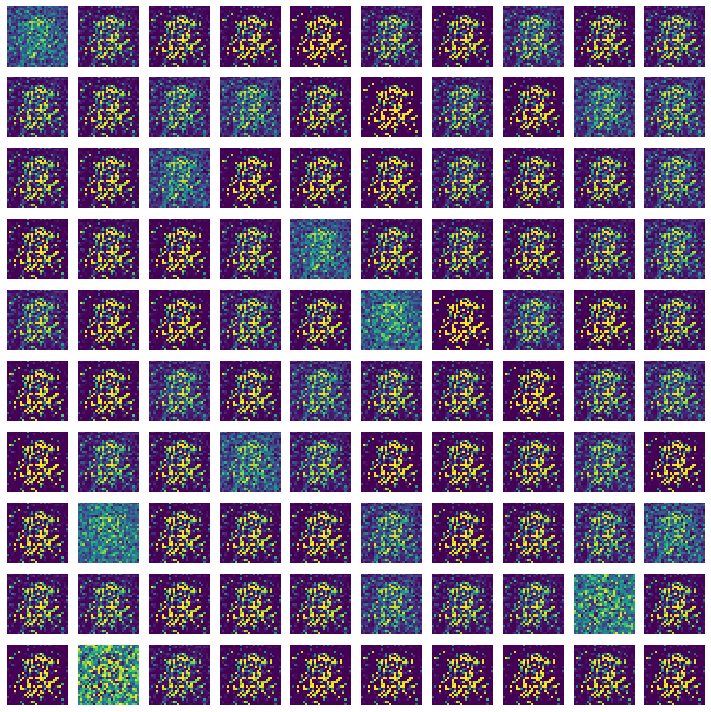

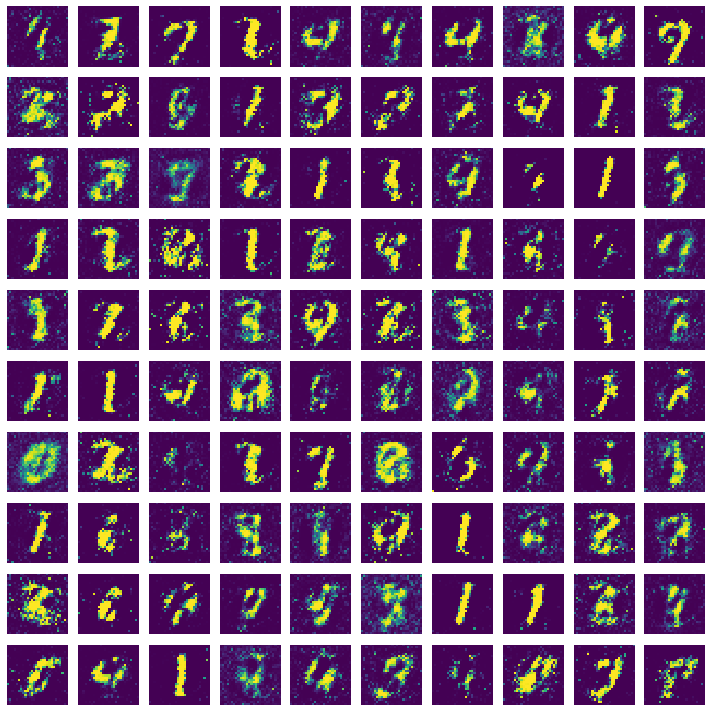

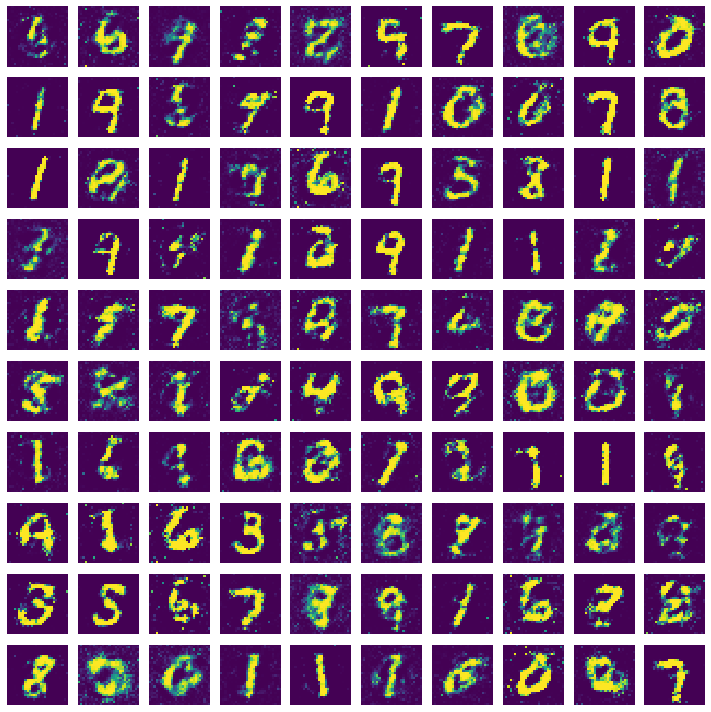

In [31]:
training(400, 128)